# Goals

### 1. Learn to implement Mobilenet V2 Linear Bottleneck Block using monk
    - Monk's Keras
    - Monk's Pytorch
    - Monk's Mxnet
    
### 2. Use network Monk's debugger to create complex blocks 


### 3. Understand how syntactically different it is to implement the same using
    - Traditional Keras
    - Traditional Pytorch
    - Traditional Mxnet

# Mobilenet V2 Linear Bottleneck Block
 
 - Note: The block structure can have variations too, this is just an example

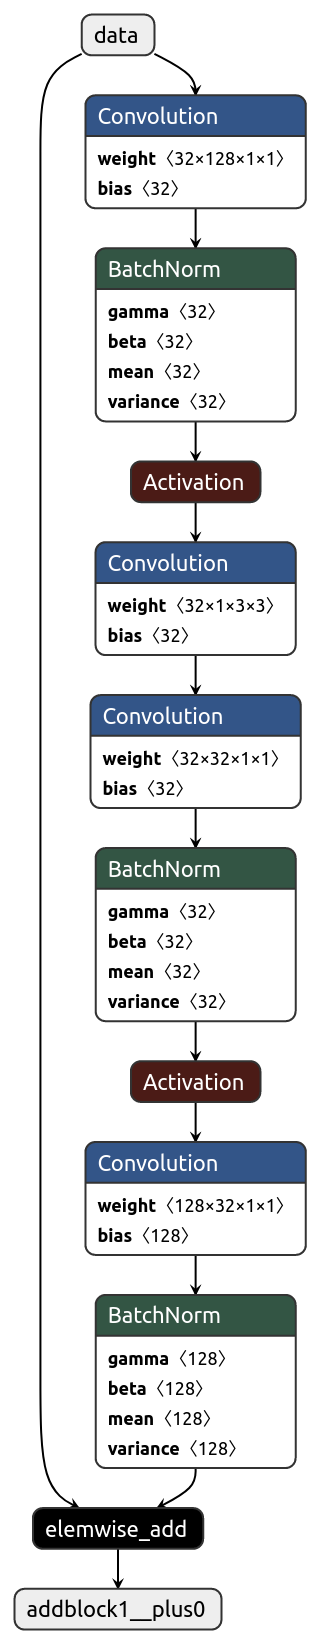

In [7]:
from IPython.display import Image
Image(filename='imgs/mobilenet_v2_inverted_linear_bottleneck.png')

# Table of contents

[1. Install Monk](#1)


[2. Block basic Information](#2)

  - [2.1) Visual structure](#2-1)
  
  - [2.2) Layers in Branches](#2-2)


[3) Creating Block using monk visual debugger](#3)

  - [3.1) Create the first branch](#3-1)

  - [3.2) Create the second branch](#3-2)
  
  - [3.3) Merge the branches](#3-3)
  
  - [3.4) Debug the merged network](#3-4)
  
  - [3.5) Compile the network](#3-5)
  
  - [3.6) Visualize the network](#3-6)
  
  - [3.7) Run data through the network](#3-7)
  
  
[4) Creating Block Using MONK one line API call](#4)

  - [Mxnet Backend](#4-1)
  
  - [Pytorch Backend](#4-2)
  
  - [Keras Backend](#4-3)
  
  
  
[5) Appendix](#5)

  - [Study Material](#5-1)
  
  - [Creating block using traditional Mxnet](#5-2)
  
  - [Creating block using traditional Pytorch](#5-3)
  
  - [Creating block using traditional Keras](#5-4)
    

<a id='1'></a>
# Install Monk
  
 - git clone https://github.com/Tessellate-Imaging/monk_v1.git
 
 - cd monk_v1/installation && pip install -r requirements_cu9.txt
     - (Select the requirements file as per OS and CUDA version)

In [ ]:
!git clone https://github.com/Tessellate-Imaging/monk_v1.git

# Imports

In [1]:
# Common
import numpy as np
import math
import netron
from collections import OrderedDict
from functools import partial

In [2]:
# Monk
import os
import sys
sys.path.append("monk_v1/monk/");

<a id='2'></a>
# Block Information

<a id='2_1'></a>
## Visual structure

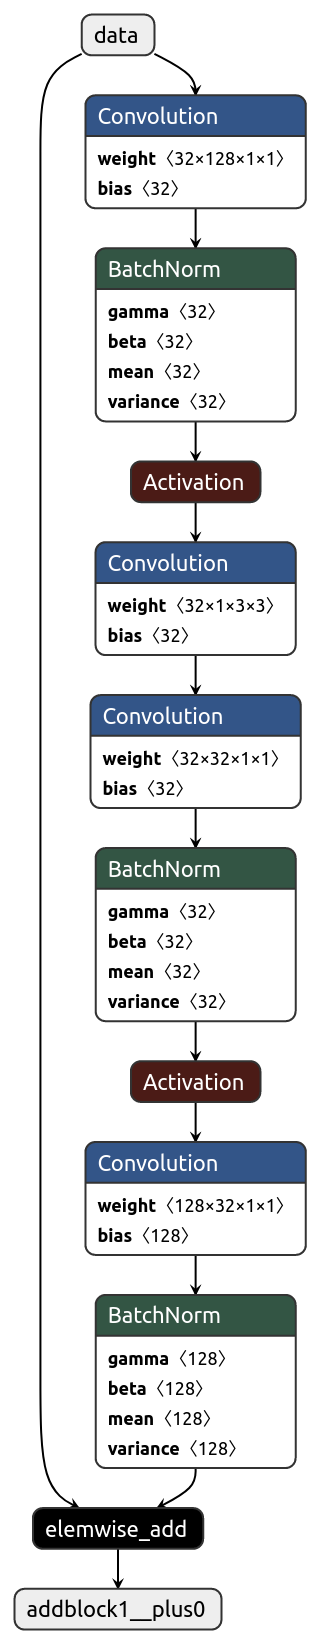

In [8]:
from IPython.display import Image
Image(filename='imgs/mobilenet_v2_inverted_linear_bottleneck.png')

<a id='2_2'></a>
## Layers in Branches

  - Number of branches: 2
  
  
  - Branch 1
    - identity
  
  
  - Branch 2
    - conv_1x1 -> batchnorm -> relu -> separable_conv_3x3 -> batchnorm -> relu -> conv_1x1 -> batchnorm
    
    
  - Branches merged using
    - Elementwise addition
    
    
(See Appendix to read blogs on mobilenet-v2)

<a id='3'></a>
# Creating Block using monk debugger

In [9]:
# Imports and setup a project
# To use pytorch backend - replace gluon_prototype with pytorch_prototype
# To use keras backend - replace gluon_prototype with keras_prototype

from gluon_prototype import prototype

# Create a sample project
gtf = prototype(verbose=1);
gtf.Prototype("sample-project-1", "sample-experiment-1");

Mxnet Version: 1.5.1

Experiment Details
    Project: sample-project-1
    Experiment: sample-experiment-1
    Dir: /home/abhi/Desktop/Work/tess_tool/gui/v0.3/finetune_models/Organization/development/v5.0_blocks/study_roadmap/blocks/workspace/sample-project-1/sample-experiment-1/



<a id='3-1'></a>
## Create the first branch

In [10]:
def first_branch():
    network = [];
    network.append(gtf.identity());
    return network;

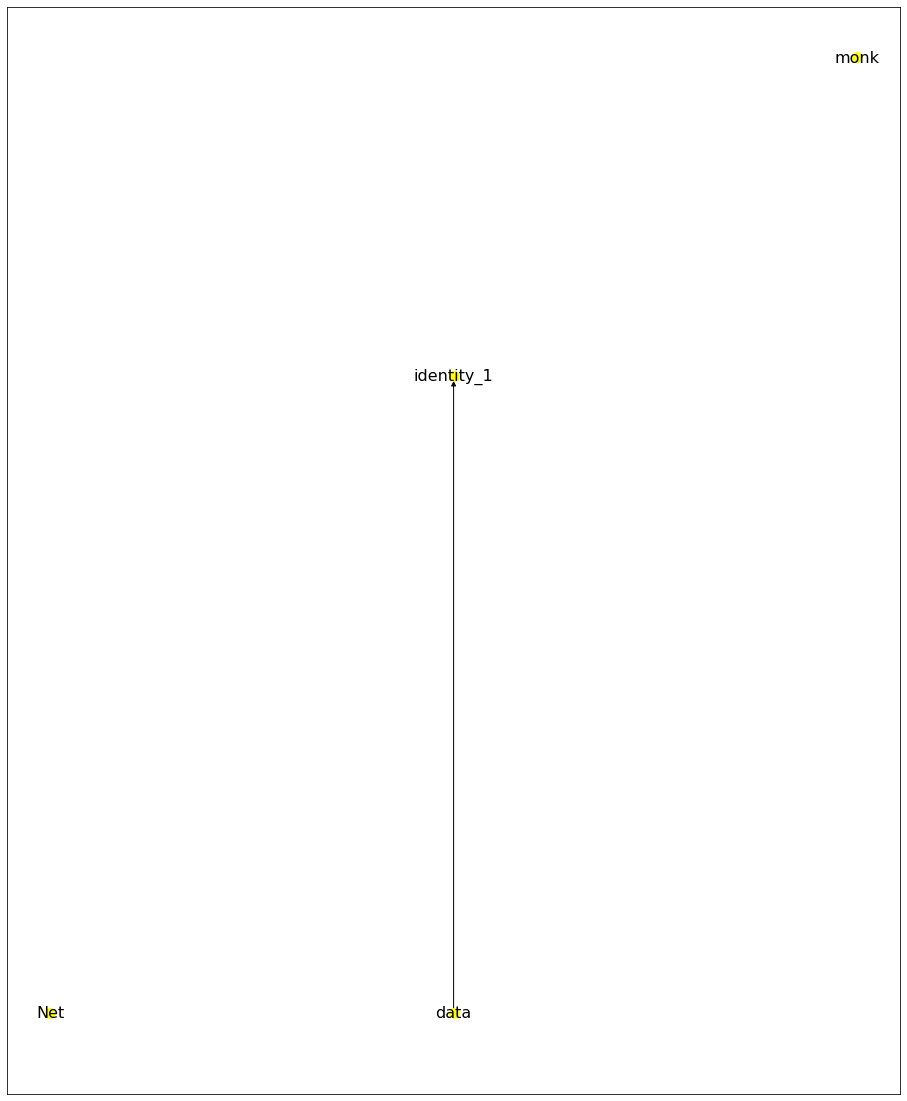

In [11]:
# Debug the branch
branch_1 = first_branch()
network = [];
network.append(branch_1);
gtf.debug_custom_model_design(network);

<a id='3-2'></a>
## Create the second branch

In [12]:
def separable_convolution_block(input_channels=16, output_channels=32, kernel_size=3, stride=1):
    network = [];
    network.append(gtf.convolution(output_channels=input_channels, kernel_size=kernel_size, 
                                   stride=stride, groups=input_channels));
    network.append(gtf.convolution(output_channels=output_channels, kernel_size=1, 
                                   stride=1));

    return network;

def second_branch(output_channels=128, bottleneck_width=4, stride=1):
    network = [];
    network.append(gtf.convolution(output_channels=output_channels//bottleneck_width, 
                                        kernel_size=1, stride=1));
    network.append(gtf.batch_normalization());
    network.append(gtf.relu());
    
    sep_conv = separable_convolution_block(input_channels=output_channels//bottleneck_width,
                                                    output_channels=output_channels//bottleneck_width,
                                                    kernel_size=3, stride=stride);
    network.append(sep_conv);   
    
    network.append(gtf.batch_normalization());
    network.append(gtf.relu());
    network.append(gtf.convolution(output_channels=output_channels, kernel_size=1, stride=1));
    network.append(gtf.batch_normalization());
    return network;

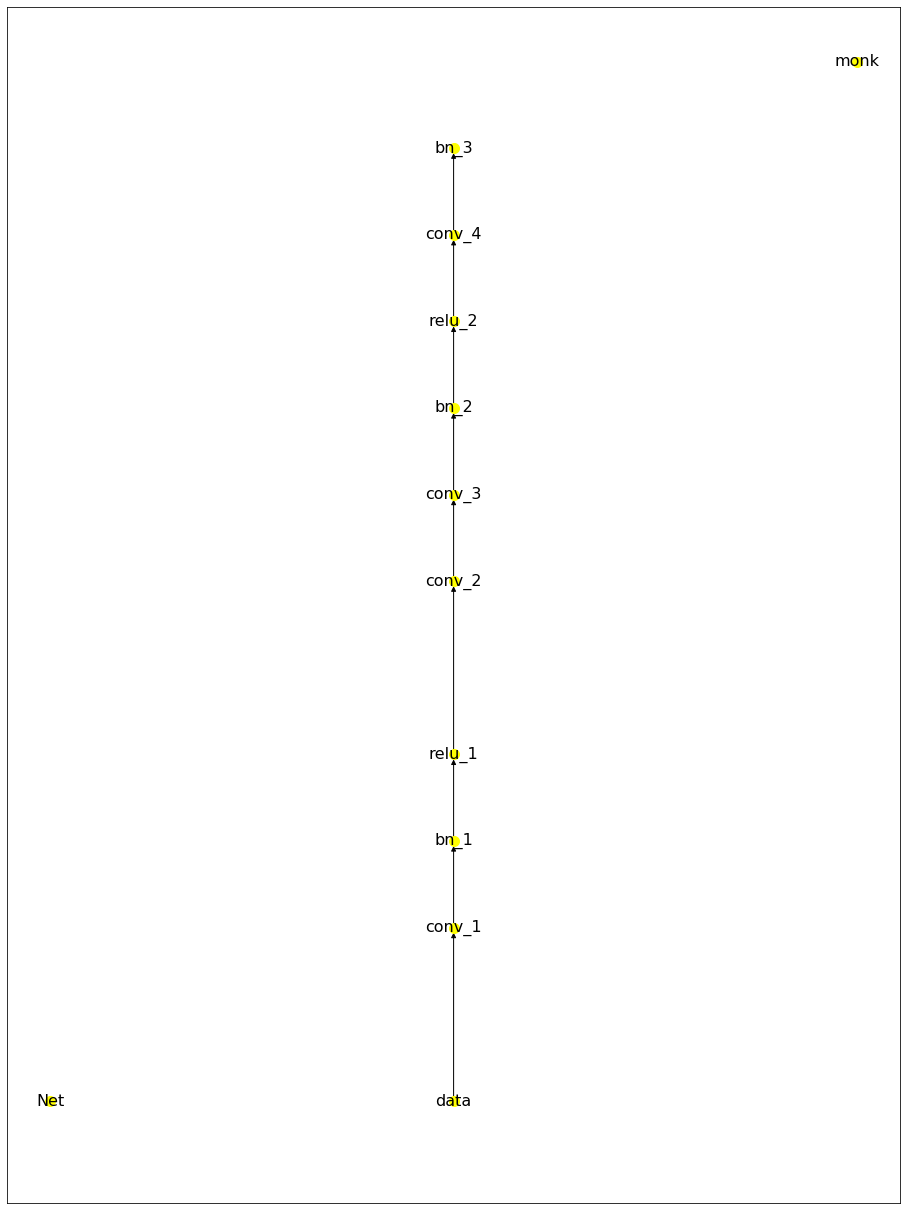

In [13]:
# Debug the branch
branch_2 = second_branch(output_channels=128, stride=1)
network = [];
network.append(branch_2);
gtf.debug_custom_model_design(network);

<a id='3-3'></a>
## Merge the branches

In [14]:

def final_block(output_channels=128, bottleneck_width=4, stride=1):
    network = [];
    
    #Create subnetwork and add branches
    subnetwork = [];
    branch_1 = first_branch()
    branch_2 = second_branch(output_channels=output_channels, 
                             bottleneck_width=bottleneck_width,
                             stride=stride)
    subnetwork.append(branch_1);
    subnetwork.append(branch_2);
    
    # Add merging element
    subnetwork.append(gtf.add());
    
    # Add the subnetwork
    network.append(subnetwork)
    return network;

<a id='3-4'></a>
## Debug the merged network

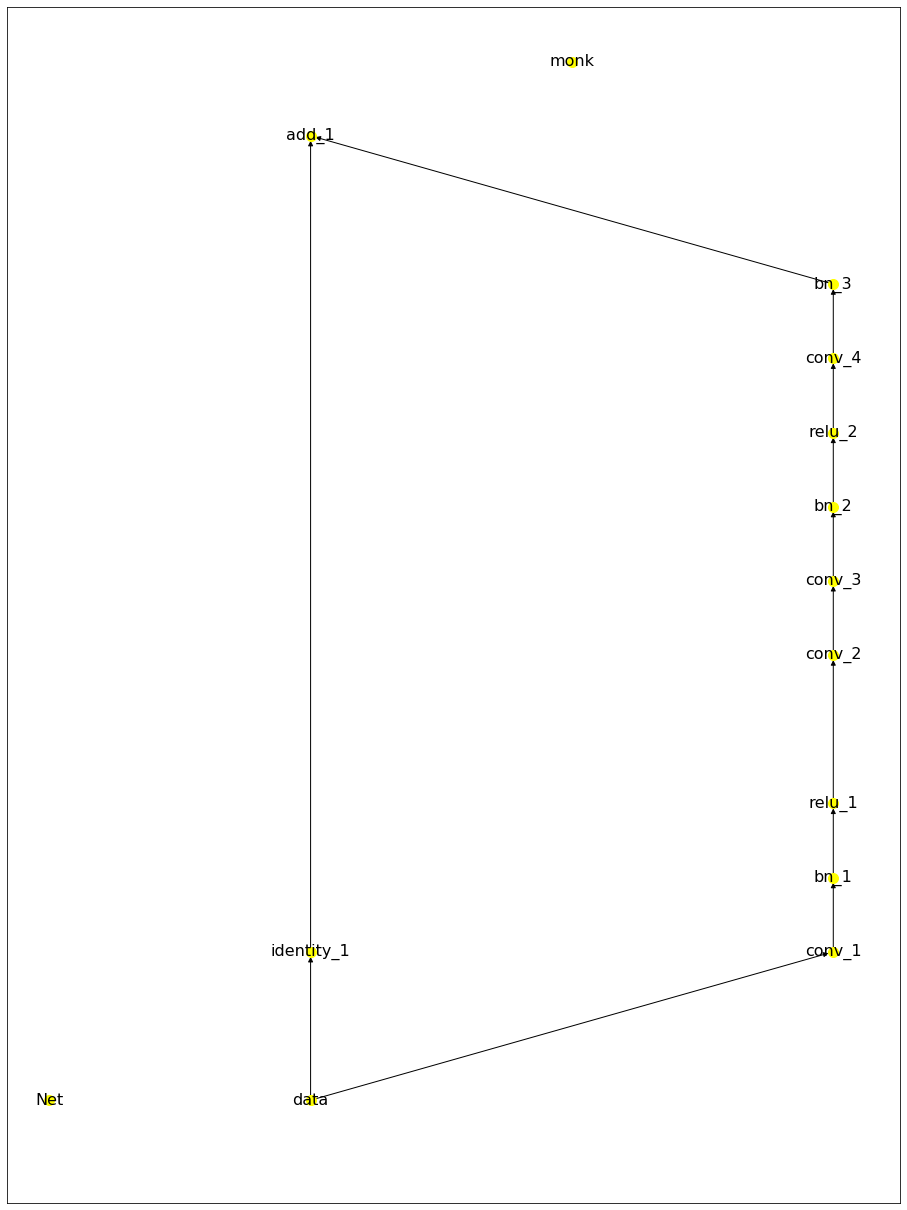

In [15]:
final = final_block(output_channels=128, stride=1)
network = [];
network.append(final);
gtf.debug_custom_model_design(network);

<a id='3-5'></a>
## Compile the network

Model Details
    Loading pretrained model
    Model Loaded on device
        Model name:                           Custom Model
        Num of potentially trainable layers:  7
        Num of actual trainable layers:       7



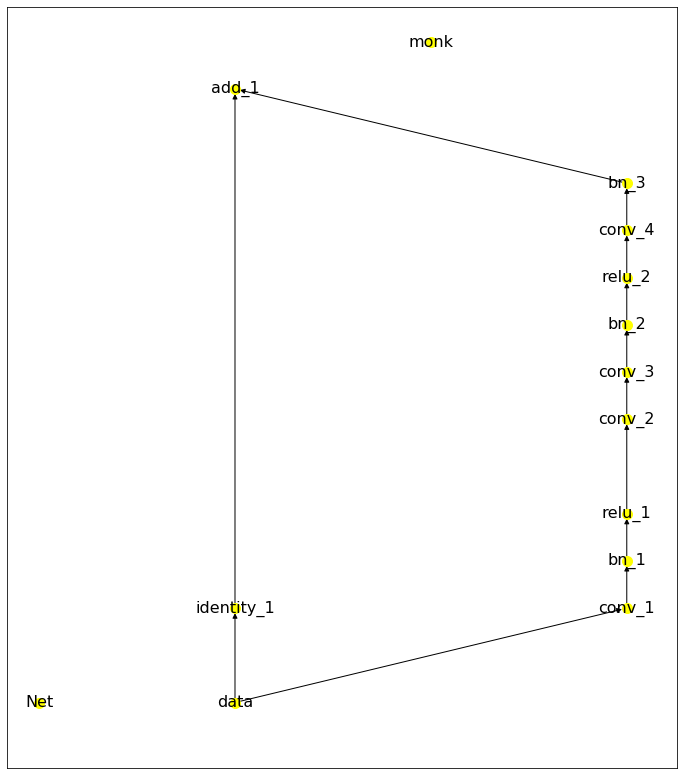

In [16]:
gtf.Compile_Network(network, data_shape=(128, 224, 224), use_gpu=False);

<a id='3-6'></a>
## Run data through the network

In [17]:
import mxnet as mx
x = np.zeros((1, 128, 224, 224));
x = mx.nd.array(x);
y = gtf.system_dict["local"]["model"].forward(x);
print(x.shape, y.shape)

(1, 128, 224, 224) (1, 128, 224, 224)


<a id='3-7'></a>
## Visualize network using netron

In [18]:
gtf.Visualize_With_Netron(data_shape=(128, 224, 224))

Using Netron To Visualize
Not compatible on kaggle
Compatible only for Jupyter Notebooks

Stopping http://localhost:8080
Serving 'model-symbol.json' at http://localhost:8080


<a id='4'></a>
# Creating Using MONK LOW code API

<a id='4-1'></a>
## Mxnet backend

Mxnet Version: 1.5.1

Experiment Details
    Project: sample-project-1
    Experiment: sample-experiment-1
    Dir: /home/abhi/Desktop/Work/tess_tool/gui/v0.3/finetune_models/Organization/development/v5.0_blocks/study_roadmap/blocks/workspace/sample-project-1/sample-experiment-1/

Model Details
    Loading pretrained model
    Model Loaded on device
        Model name:                           Custom Model
        Num of potentially trainable layers:  7
        Num of actual trainable layers:       7



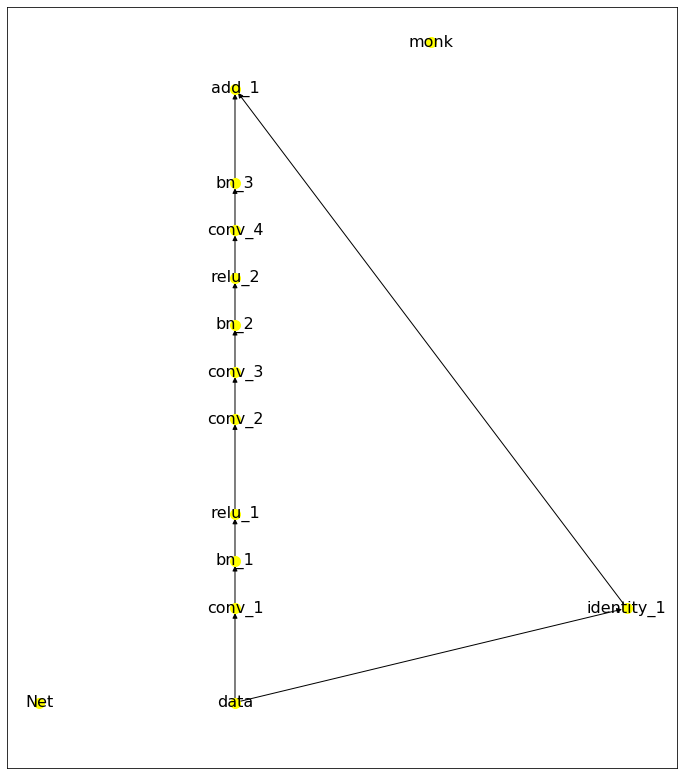

In [19]:
from gluon_prototype import prototype
gtf = prototype(verbose=1);
gtf.Prototype("sample-project-1", "sample-experiment-1");


network = [];

# Single line addition of blocks
network.append(gtf.mobilenet_v2_inverted_linear_bottleneck_block(output_channels=128, bottleneck_width=4));


gtf.Compile_Network(network, data_shape=(128, 224, 224), use_gpu=False);


<a id='4-2'></a>
## Pytorch backend

  - Only the import changes

Pytorch Version: 1.2.0

Experiment Details
    Project: sample-project-1
    Experiment: sample-experiment-1
    Dir: /home/abhi/Desktop/Work/tess_tool/gui/v0.3/finetune_models/Organization/development/v5.0_blocks/study_roadmap/blocks/workspace/sample-project-1/sample-experiment-1/

Model Details
    Loading pretrained model
    Model Loaded on device
        Model name:                           Custom Model
        Num layers in model:  7
        Num trainable layers: 7



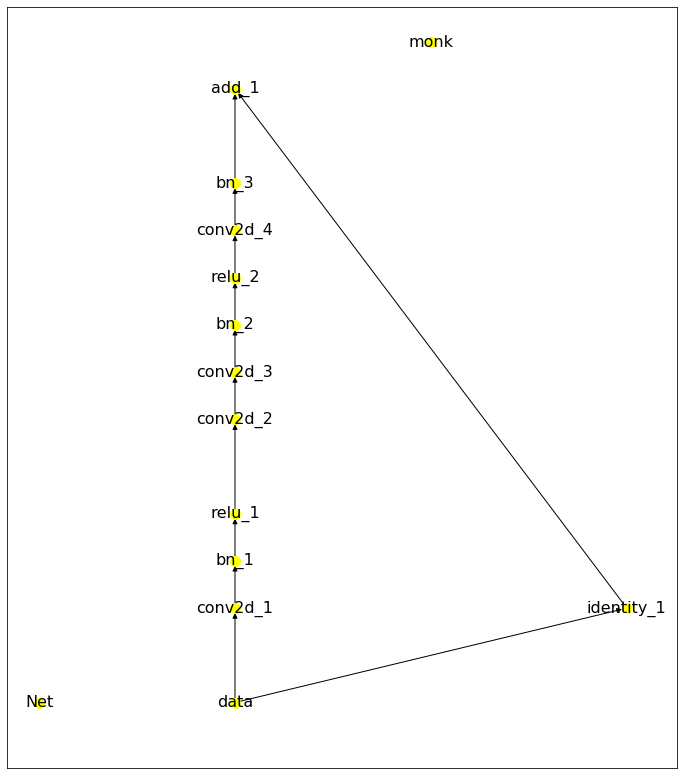

In [20]:
#Change gluon_prototype to pytorch_prototype
from pytorch_prototype import prototype


gtf = prototype(verbose=1);
gtf.Prototype("sample-project-1", "sample-experiment-1");


network = [];

# Single line addition of blocks
network.append(gtf.mobilenet_v2_inverted_linear_bottleneck_block(output_channels=128, bottleneck_width=4));


gtf.Compile_Network(network, data_shape=(128, 224, 224), use_gpu=False);

<a id='4-3'></a>
## Keras backend

  - Only the import changes

Keras Version: 2.2.5
Tensorflow Version: 1.12.0

Experiment Details
    Project: sample-project-1
    Experiment: sample-experiment-1
    Dir: /home/abhi/Desktop/Work/tess_tool/gui/v0.3/finetune_models/Organization/development/v5.0_blocks/study_roadmap/blocks/workspace/sample-project-1/sample-experiment-1/

Model Details
    Loading pretrained model
    Model Loaded on device
        Model name:                           Custom Model
        Num layers in model:  11
        Num trainable layers: 10



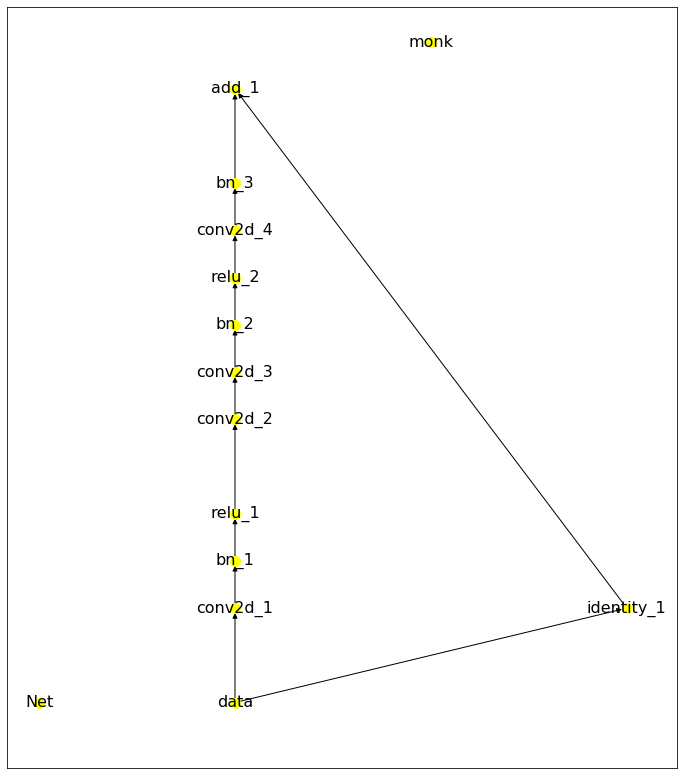

In [21]:
#Change gluon_prototype to keras_prototype
from keras_prototype import prototype


gtf = prototype(verbose=1);
gtf.Prototype("sample-project-1", "sample-experiment-1");


network = [];

# Single line addition of blocks
network.append(gtf.mobilenet_v2_inverted_linear_bottleneck_block(output_channels=128, bottleneck_width=4));


gtf.Compile_Network(network, data_shape=(128, 224, 224), use_gpu=False);

<a id='5'></a>
# Appendix

<a id='5-1'></a>
## Study links
  - https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html
  - https://machinethink.net/blog/mobilenet-v2/
  - https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c
  - https://towardsdatascience.com/mobilenetv2-inverted-residuals-and-linear-bottlenecks-8a4362f4ffd5
  - https://medium.com/@luis_gonzales/a-look-at-mobilenetv2-inverted-residuals-and-linear-bottlenecks-d49f85c12423

<a id='5-2'></a>
## Creating block using traditional Mxnet

 - Code credits - https://mxnet.incubator.apache.org/

In [22]:
# Traditional-Mxnet-gluon
import mxnet as mx
from mxnet.gluon import nn
from mxnet.gluon.nn import HybridBlock, BatchNorm
from mxnet.gluon.contrib.nn import HybridConcurrent, Identity
from mxnet import gluon, init, nd

In [23]:

def _add_conv(out, channels=1, kernel=1, stride=1, pad=0,
              num_group=1, active=True, relu6=False, norm_layer=BatchNorm, norm_kwargs=None):
    out.add(nn.Conv2D(channels, kernel, stride, pad, groups=num_group, use_bias=False))
    out.add(norm_layer(scale=True, **({} if norm_kwargs is None else norm_kwargs)))
    if active:
        out.add(nn.Activation('relu'))

class InvertedLinearBottleneck(nn.HybridBlock):

    def __init__(self, in_channels, channels, t, stride,
                 norm_layer=BatchNorm, norm_kwargs=None, **kwargs):
        super(InvertedLinearBottleneck, self).__init__(**kwargs)
        self.use_shortcut = stride == 1 and in_channels == channels
        with self.name_scope():
            self.out = nn.HybridSequential()
            if t != 1:
                _add_conv(self.out,
                          in_channels // t,
                          relu6=True,
                          norm_layer=norm_layer, norm_kwargs=norm_kwargs)
            _add_conv(self.out,
                      in_channels // t,
                      kernel=3,
                      stride=stride,
                      pad=1,
                      num_group=in_channels // t,
                      relu6=True,
                      norm_layer=norm_layer, norm_kwargs=norm_kwargs)
            _add_conv(self.out,
                      channels,
                      active=False,
                      relu6=True,
                      norm_layer=norm_layer, norm_kwargs=norm_kwargs)

    def hybrid_forward(self, F, x):
        out = self.out(x)
        if self.use_shortcut:
            out = F.elemwise_add(out, x)
        return out

In [25]:
# Invoke the block
block = InvertedLinearBottleneck(64, 64, 4, 1)

# Initialize network and load block on machine
ctx = [mx.cpu()];
block.initialize(init.Xavier(), ctx = ctx);
block.collect_params().reset_ctx(ctx)
block.hybridize()

# Run data through network
x = np.zeros((1, 64, 224, 224));
x = mx.nd.array(x);
y = block.forward(x);
print(x.shape, y.shape)


# Export Model to Load on Netron
block.export("final", epoch=0);

netron.start("final-symbol.json", port=8082)

(1, 64, 224, 224) (1, 64, 224, 224)
Serving 'final-symbol.json' at http://localhost:8082


<a id='5-3'></a>
## Creating block using traditional Pytorch

 - Code credits - https://github.com/pytorch/vision/blob/master/torchvision/models/mobilenet.py

In [26]:
# Traiditional-Pytorch
import torch
from torch import nn
from torch.jit.annotations import List
import torch.nn.functional as F

In [27]:
class ConvBNReLU(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_planes),
            nn.ReLU6(inplace=True)
        )


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(round(inp // expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers = []
        if expand_ratio != 1:
            # pw
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1))
        layers.extend([
            # dw
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim),
            # pw-linear
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

In [28]:
# Invoke the block
block = InvertedResidual(64, 64, 1, 4);

# Initialize network and load block on machine
layers = []
layers.append(block);
net = nn.Sequential(*layers);

# Run data through network
x = torch.randn(1, 64, 224, 224)
y = net(x)
print(x.shape, y.shape);

# Export Model to Load on Netron
torch.onnx.export(net,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "model.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}})
netron.start('model.onnx', port=9998);


torch.Size([1, 64, 224, 224]) torch.Size([1, 64, 224, 224])
Serving 'model.onnx' at http://localhost:9998


<a id='5-4'></a>
## Creating block using traditional Keras

 - Code credits: https://github.com/xiaochus/MobileNetV2/blob/master/mobilenet_v2.py

In [29]:
# Traditional-Keras
import keras
import keras.layers as kla
import keras.models as kmo
import tensorflow as tf
from keras.models import Model
backend = 'channels_last'
from keras import layers
from keras.layers import *
from keras import backend as K

In [30]:
def relu6(x):
    return K.relu(x, max_value=6.0)


def _conv_block(inputs, filters, kernel, strides):

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x = Conv2D(filters, kernel, padding='same', strides=strides)(inputs)
    x = BatchNormalization(axis=channel_axis)(x)
    return Activation(relu6)(x)


def _bottleneck(inputs, filters, kernel, t, alpha, s, r=False):

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    # Depth
    tchannel = K.int_shape(inputs)[channel_axis] // t
    # Width
    cchannel = int(filters * alpha)

    x = _conv_block(inputs, tchannel, (1, 1), (1, 1))

    x = DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation(relu6)(x)

    x = Conv2D(cchannel, (1, 1), strides=(1, 1), padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)

    if r:
        x = Add()([x, inputs])

    return x


def create_model(input_shape, kernel_size, filters, bottleneck_width, stride=1):
    img_input = layers.Input(shape=input_shape);
    x = _bottleneck(img_input, filters, kernel_size, bottleneck_width, 1, stride, r=True)    
    return Model(img_input, x);

In [31]:
# Invoke the block
kernel_size=3;
filters=64;
input_shape=(224, 224, 64);
model = create_model(input_shape, kernel_size, filters, 4);

# Run data through network
x = tf.placeholder(tf.float32, shape=(1, 224, 224, 64))
y = model(x)
print(x.shape, y.shape)

# Export Model to Load on Netron
model.save("final.h5");
netron.start("final.h5", port=8082)

(1, 224, 224, 64) (1, 224, 224, 64)

Stopping http://localhost:8082
Serving 'final.h5' at http://localhost:8082
